In [50]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import sunode.wrappers.as_pytensor

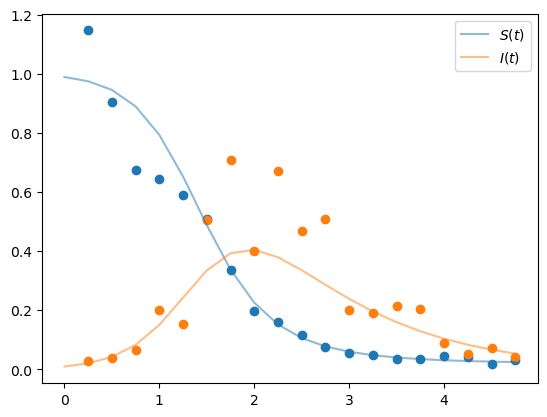

In [2]:
def SIR(y, t, p):
    ds = -p[0] * y[0] * y[1]
    di = p[0] * y[0] * y[1] - p[1] * y[1]
    return [ds, di]


times = np.arange(0, 5, 0.25)

beta, gamma = 4, 1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta, gamma),), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

plt.plot(times[1::], yobs, marker="o", linestyle="none")
plt.plot(times, y[:, 0], color="C0", alpha=0.5, label=f"$S(t)$")
plt.plot(times, y[:, 1], color="C1", alpha=0.5, label=f"$I(t)$")
plt.legend()
plt.show()

In [58]:
sir_model = pm.ode.DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:
    sigma = pm.HalfCauchy("sigma", 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occurred
    R0 = pm.Normal("R0", 2, 3)
    lam = pm.Lognormal("lambda", pm.math.log(2), 2)
    beta = pm.Deterministic("beta", lam * R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal("Y", mu=pm.math.log(sir_curves), sigma=sigma, observed=yobs)

    trace = pm.sample(2000, tune=1000, target_accept=0.9, cores=4)
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, R0, lambda]


Output()

ValueError: Not enough samples to build a trace.

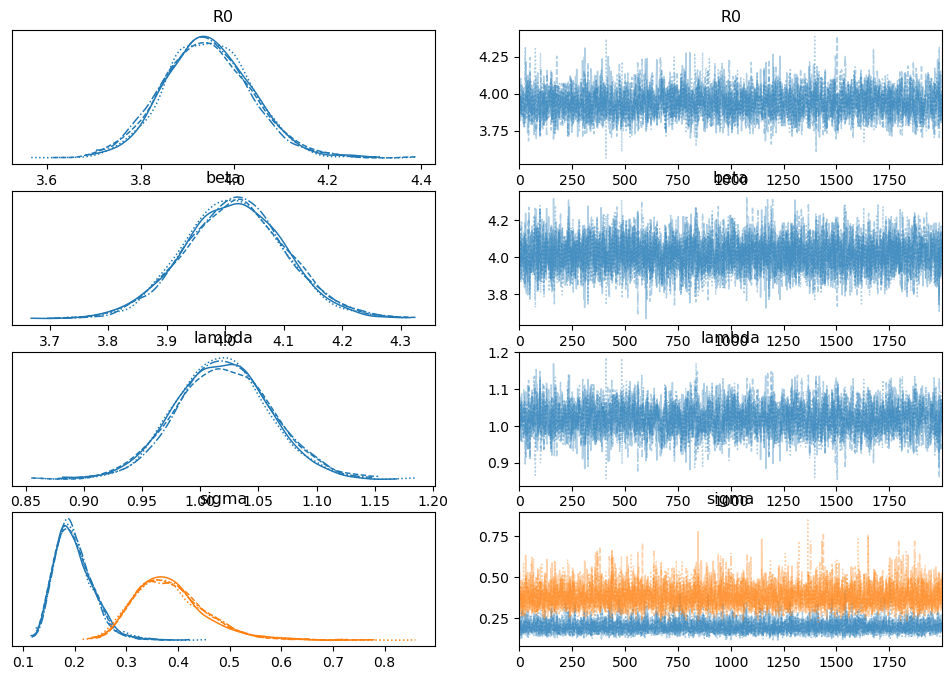

In [6]:
az.plot_trace(trace)
plt.show()

In [16]:
ppc = pm.sample_posterior_predictive(trace, var_names=['Y'], model=model4)

Sampling: [Y]


Output()

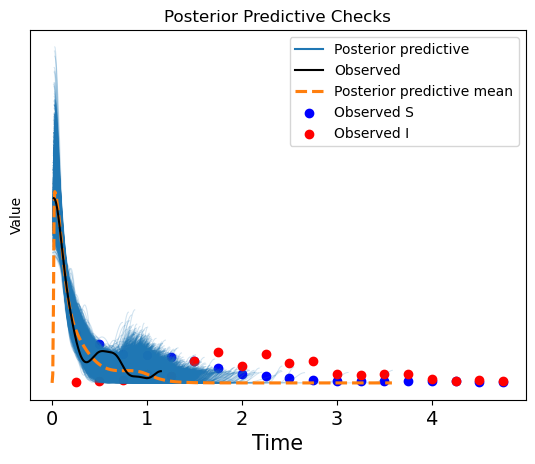

In [18]:
az.plot_ppc(ppc)
plt.scatter(np.arange(0.25, 5, 0.25), yobs[:, 0], c='blue', label='Observed S')
plt.scatter(np.arange(0.25, 5, 0.25), yobs[:, 1], c='red', label='Observed I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Posterior Predictive Checks')
plt.show()

In [178]:


def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'S': p.alpha * (1-y.S-y.I) - p.R_0*p.gamma * y.S * y.I,
        'I': p.R_0*p.gamma * y.S * y.I - p.gamma * y.I,
    }


with pm.Model() as model:
    
    # Compute the parameters of the ode based on our prior parameters
    sigma = pm.HalfCauchy("sigma", 1,shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occurred
    
    R_0 = pm.LogNormal("R_0", 2, 3)
    lam = pm.LogNormal("lambda", 1, 2)
    beta = pm.Deterministic("beta", lam * R_0)
    gamma = pm.LogNormal('gamma', mu=1, sigma=0.1)
    S_start=0.99 
    I_start=0.01
    alpha=0 
    extra=0
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
            'S': (S_start, ()),  # Ensure shape is ()
            'I': (I_start, ()),  # Ensure shape is ()
        },
        params={
            'alpha': (alpha, ()),
            'R_0': (R_0, ()),  # Ensure shape is (100,)
            'beta': (beta, ()),
            'gamma': (gamma, ()),
            'extra': (extra, ()),
        },
        rhs=lotka_volterra,
        tvals=times,
        t0=times[0],
    )
        
    
# We can access the individual variables of the solution using the
# variable names.
    pm.Deterministic('S_mu', pm.math.clip(y_hat['S'], 0, 1))
    pm.Deterministic('I_mu', pm.math.clip(y_hat['I'], 0, 1))
    S = pm.Normal("S", mu=y_hat['S'], sigma=sigma[0], observed=y[:, 0])
    I = pm.Normal("I", mu=y_hat['I'], sigma=sigma[1], observed=y[:, 1])
    
    trace = pm.sample(1000, tune=1000, cores=2, return_inferencedata=True)

    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, R_0, lambda, gamma]


Output()


[CVODES ERROR]  CVode
  At t = 0.000802312, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00216977, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000980484, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00172983, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000117824, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00216977, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0




Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 802 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics



[CVODES ERROR]  CVode
  At t = 0.000351411, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00212529, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000714337, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODEA ERROR]  CVodeF
  At t = 0.246516, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.246516, mxstep steps taken before reaching tout.


[CVODES ERROR]  CVode
  At t = 0.00239883, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00192803, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00158106, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0013527, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00117429, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00125422, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00141936, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000749947, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CV


[CVODES ERROR]  CVode
  At t = 0.00281209, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.002169, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00592202, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00213562, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00174384, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00236544, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVOD


[CVODES ERROR]  CVode
  At t = 0.00191516, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00132813, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0013137, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000269793, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00127488, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00088759, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CV


[CVODES ERROR]  CVode
  At t = 0.000773596, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000553414, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000875596, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000759396, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000757332, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODEA ERROR]  CVodeF
  At t = 0.23498, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.23498, mxstep steps taken before reaching tout


[CVODES ERROR]  CVode
  At t = 0.00190877, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00173657, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000929432, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000597494, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00095884, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00129856, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[


[CVODES ERROR]  CVode
  At t = 0.00204906, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00103016, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00235533, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000696329, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00240255, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00091649, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[C


[CVODES ERROR]  CVode
  At t = 0.00139857, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00119071, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00119156, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000922491, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00191206, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00181497, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[C


[CVODES ERROR]  CVode
  At t = 0.00195519, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00204726, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00330577, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00066223, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00197337, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00270624, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CV


[CVODES ERROR]  CVode
  At t = 0.00049158, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000591661, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00123075, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODEA ERROR]  CVodeF
  At t = 0.235869, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.235869, mxstep steps taken before reaching tout.


[CVODES ERROR]  CVode
  At t = 0.00183673, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0201438, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0




[CVODES ERROR]  CVode
  At t = 0.00131951, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00125222, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0018183, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00220406, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000824098, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000367466, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[C


[CVODES ERROR]  CVode
  At t = 0.0256859, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.255924, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000169029, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODEA ERROR]  CVodeF
  At t = 0.24318, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.24318, mxstep steps taken before reaching tout.


[CVODES ERROR]  CVode
  At t = 0.000182516, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000256056, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[


[CVODES ERROR]  CVode
  At t = 0.000518466, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00132142, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00113207, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00137467, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000940874, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00169723, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[


[CVODES ERROR]  CVode
  At t = 0.00152097, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00162347, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00106423, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00140237, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00174611, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00143827, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CV


[CVODES ERROR]  CVode
  At t = 0.000663316, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000698335, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00118653, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000706151, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00109809, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00060061, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0





[CVODES ERROR]  CVode
  At t = 0.00187797, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00150003, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00135927, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00149724, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00234706, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00170258, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CV


[CVODES ERROR]  CVode
  At t = 0.00113783, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0024217, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0015992, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00135508, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00176486, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00173189, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVOD


[CVODES ERROR]  CVode
  At t = 0.00034134, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00244448, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00177146, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00252105, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00179515, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00250399, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CV


[CVODES ERROR]  CVode
  At t = 0.0011477, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00160926, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00148018, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.0022741, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00163134, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00237879, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVOD


[CVODES ERROR]  CVode
  At t = 0.00154807, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000171511, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00107845, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00162225, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00299349, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00637073, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[C


[CVODES ERROR]  CVode
  At t = 0.00184619, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00305822, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00252198, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00207524, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00108702, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00101708, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CV


[CVODES ERROR]  CVode
  At t = 0.00162546, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00134135, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00129169, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODEA ERROR]  CVodeF
  At t = 0.228366, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.228366, mxstep steps taken before reaching tout.


[CVODES ERROR]  CVode
  At t = 0.00186174, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00188136, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0




[CVODES ERROR]  CVode
  At t = 0.000433351, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000376037, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000336592, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000668349, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000401322, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000900263, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00150787, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00120249, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00146334, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000970305, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.00157206, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 0.000691763, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[


[CVODES ERROR]  CVode
  At t = 0.00114817, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0



Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 802 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [179]:
ppc = pm.sample_posterior_predictive(trace, var_names=['S','I'], model=model)
ppc
#plt.scatter(np.arange(0.25, 5, 0.25), yobs[:, 0], c='blue', label='Observed S')
#plt.scatter(np.arange(0.25, 5, 0.25), yobs[:, 1], c='red', label='Observed I')


Sampling: [I, S]


Output()

Inference data with groups:
	> posterior_predictive
	> observed_data

In [180]:
ppc_I=ppc.posterior_predictive.I

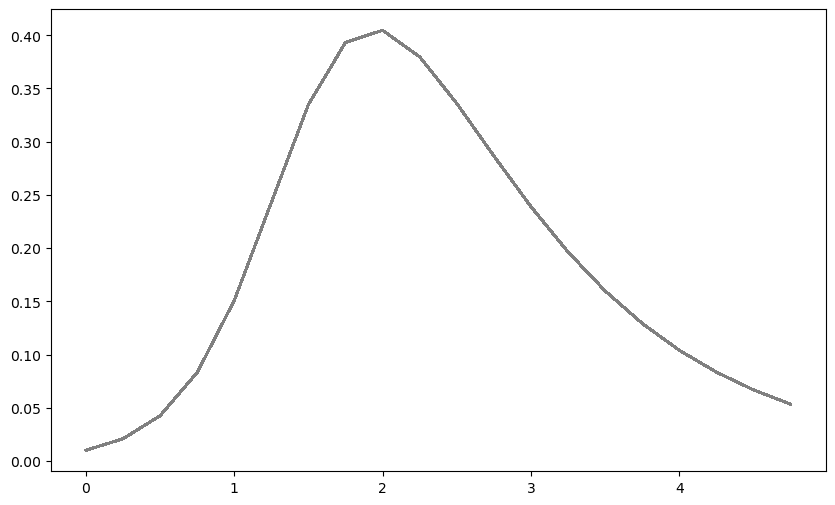

In [181]:
plt.figure(figsize=(10, 6))
for sample in ppc_I[0,:,:]:
    plt.plot(times, sample, color='gray', alpha=0.5)


In [182]:
summary = az.summary(trace)
print(summary)

             mean        sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
I_mu[0]     0.010     0.000   0.010    0.010      0.000    0.000    2000.0   
I_mu[1]     0.021     0.000   0.021    0.021      0.000    0.000    1864.0   
I_mu[2]     0.042     0.000   0.042    0.042      0.000    0.000    1865.0   
I_mu[3]     0.083     0.000   0.083    0.083      0.000    0.000    1871.0   
I_mu[4]     0.151     0.000   0.151    0.151      0.000    0.000    1873.0   
I_mu[5]     0.243     0.000   0.243    0.243      0.000    0.000    1863.0   
I_mu[6]     0.335     0.000   0.335    0.335      0.000    0.000    1841.0   
I_mu[7]     0.393     0.000   0.393    0.393      0.000    0.000    1778.0   
I_mu[8]     0.405     0.000   0.405    0.405      0.000    0.000    1706.0   
I_mu[9]     0.380     0.000   0.380    0.380      0.000    0.000    1687.0   
I_mu[10]    0.336     0.000   0.336    0.336      0.000    0.000    1681.0   
I_mu[11]    0.287     0.000   0.287    0.287      0.000    0.000

/Users/guttorm/anaconda3/envs/dyn_sys/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/Users/guttorm/anaconda3/envs/dyn_sys/lib/python3.11/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


In [111]:
times

array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
       2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75])

/Users/guttorm/anaconda3/envs/dyn_sys/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/guttorm/anaconda3/envs/dyn_sys/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


array([[<Axes: title={'center': 'I_mu'}>,
        <Axes: title={'center': 'I_mu'}>],
       [<Axes: title={'center': 'R_0'}>, <Axes: title={'center': 'R_0'}>],
       [<Axes: title={'center': 'S_mu'}>,
        <Axes: title={'center': 'S_mu'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>],
       [<Axes: title={'center': 'gamma'}>,
        <Axes: title={'center': 'gamma'}>],
       [<Axes: title={'center': 'lambda'}>,
        <Axes: title={'center': 'lambda'}>],
       [<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>]], dtype=object)

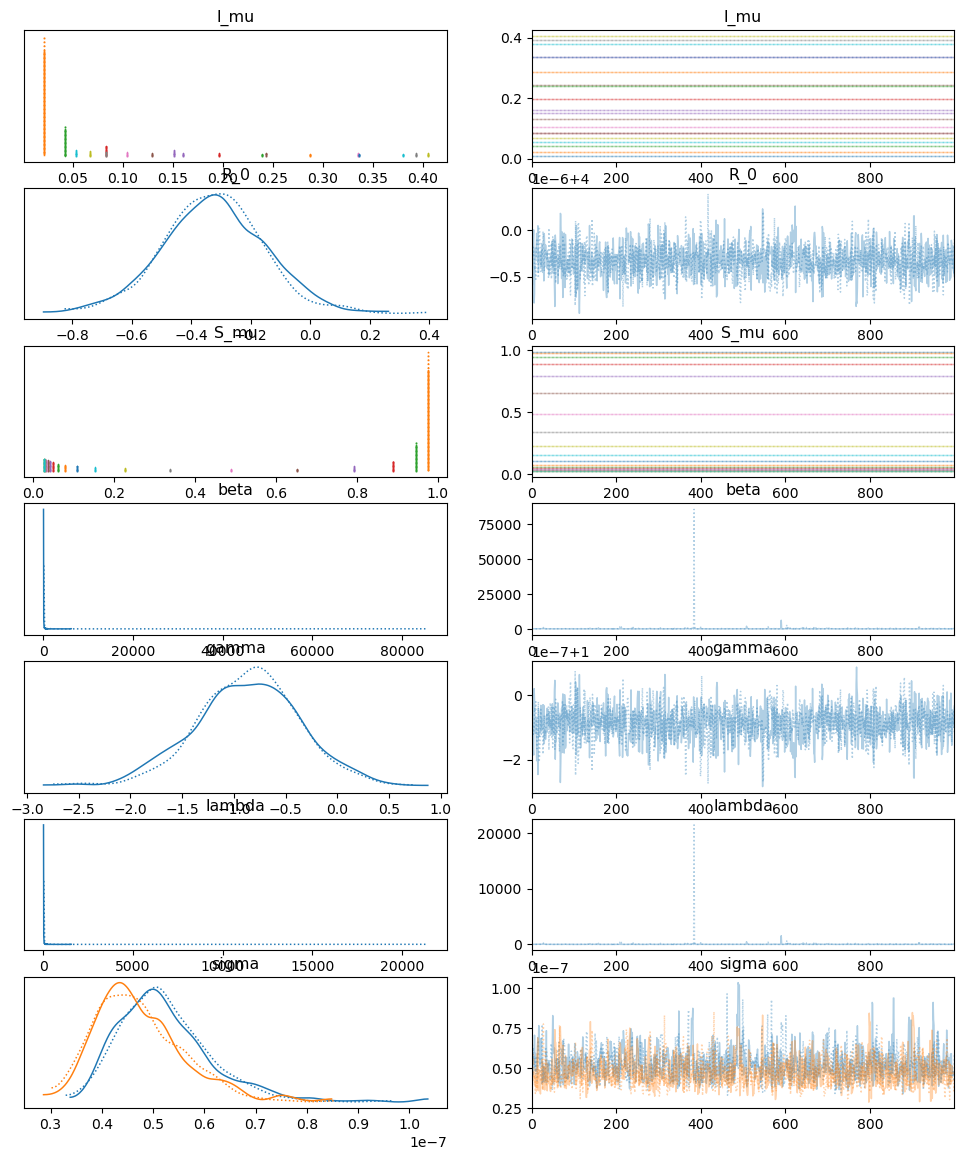

In [183]:
az.plot_trace(trace)



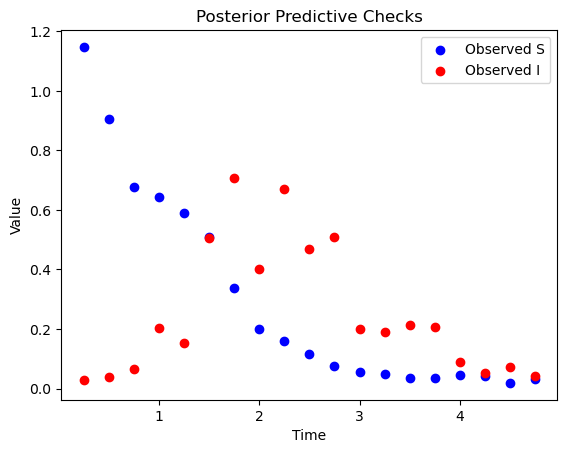

In [113]:

plt.scatter(times[1:], yobs[:, 0], c='blue', label='Observed S')
plt.scatter(times[1:], yobs[:, 1], c='red', label='Observed I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Posterior Predictive Checks')
plt.show()

In [100]:
import numpy as np
import sunode
import sunode.wrappers.as_pytensor
import pymc as pm
import matplotlib.pyplot as plt
import sympy as sp

# Time points
t = np.linspace(0, 100, 100)
times = np.arange(0, 5, 0.25)
# Observed R values (example data)
R_obs = np.array([0.78843596, 0.71150383, 0.66289627, 0.64019564, 0.63681664,
                  0.6445331, 0.66119279, 0.68034687, 0.6983999, 0.71331924,
                  0.72873873, 0.73886516, 0.7501649, 0.76678487, 0.77994872,
                  0.7942952, 0.80841032, 0.82774465, 0.84001028, 0.84352969,
                  0.84642354, 0.84616422, 0.84338121, 0.83374183, 0.82259294,
                  0.81345853, 0.80554934, 0.79795632, 0.78799997, 0.78669823,
                  0.79520117, 0.80754271, 0.8283006, 0.85634427, 0.89385511,
                  0.93620753, 0.97208123, 1.00983813, 1.03529901, 1.05014702,
                  1.06611123, 1.08140734, 1.09290491, 1.09983065, 1.09641181,
                  1.11140258, 1.12982013, 1.14538746, 1.16677504, 1.1804819,
                  1.18267914, 1.18360481, 1.16307675, 1.13732533, 1.12099681,
                  1.0982526, 1.07766902, 1.06453642, 1.05820409, 1.04992038,
                  1.04277409, 1.0397242, 1.04208068, 1.04451385, 1.05210841,
                  1.06788159, 1.07745923, 1.07809487, 1.06370824, 1.04013859,
                  1.01094897, 0.97686433, 0.93662186, 0.89594093, 0.8590])

def lotka_volterra(t, y, p):
    """Right hand side of Lotka-Volterra equation.

    All inputs are dataclasses of sympy variables, or in the case
    of non-scalar variables numpy arrays of sympy variables.
    """
    return {
        'S': p.alpha * (1-y.S-y.I) - p.R_0*p.gamma * y.S * y.I,
        'I': p.R_0*p.gamma * y.S * y.I - p.gamma * y.I,
    }


with pm.Model() as model:
    S_start = pm.HalfNormal('S_start', sigma=0.1)
    I_start = pm.HalfNormal('I_start', sigma=0.1)
    
    
    
    # Compute the parameters of the ode based on our prior parameters
    alpha = 0. #pm.Deterministic('alpha', np.array(0))
    beta = pm.Normal('beta', mu=0.1, sigma=0.01)
    gamma = pm.Normal('gamma', mu=0.1, sigma=0.01)
    R_0 = pm.Normal('R_0', mu=1, sigma=0.1)#, observed=R_obs)
    
    
    y_hat, _, problem, solver, _, _ = sunode.wrappers.as_pytensor.solve_ivp(
        y0={
            'S': (S_start, ()),  # Ensure shape is ()
            'I': (I_start, ()),  # Ensure shape is ()
        },
        params={
            'alpha': (alpha, ()),
            'R_0': (R_0, ()),  # Ensure shape is (100,)
            'beta': (beta, ()),
            'gamma': (gamma, ()),
        },
        rhs=lotka_volterra,
        tvals=times[1:],
        t0=times[1],
    )
        
    
    # We can access the individual variables of the solution using the
    # variable names.
    pm.Deterministic('S_mu', y_hat['S'])
    pm.Deterministic('I_mu', y_hat['I'])

    sd = pm.HalfNormal('sd')
    S = pm.LogNormal('S', mu=np.log(y_hat['S']), sigma=sd, observed=yobs[:, 0])
    I = pm.LogNormal('I', mu=np.log(y_hat['I']), sigma=sd, observed=yobs[:, 1])
    
    trace = pm.sample(1000, tune=1000, cores=2, return_inferencedata=True)

    


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [S_start, I_start, beta, gamma, R_0, sd]


Output()


[CVODEA ERROR]  CVodeF
  At t = 0.495869, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeF
  At t = 0.495869, mxstep steps taken before reaching tout.


[CVODES ERROR]  CVode
  The right-hand side routine failed at the first call.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 4.74247, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 4.73437, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 4.7246, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CVode
  At t = 4.49402, mxstep steps taken before reaching tout.


[CVODEA ERROR]  CVodeB
  Error occured while integrating backward problem # 0


[CVODES ERROR]  CV

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 16 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [71]:
az.plot_ppc(trace)
plt.scatter(times[1:], yobs[:, 0], c='blue', label='Observed S')
plt.scatter(times[1:], yobs[:, 1], c='red', label='Observed I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Posterior Predictive Checks')
plt.show()


TypeError: `data` argument must have the group "posterior_predictive" for ppcplot

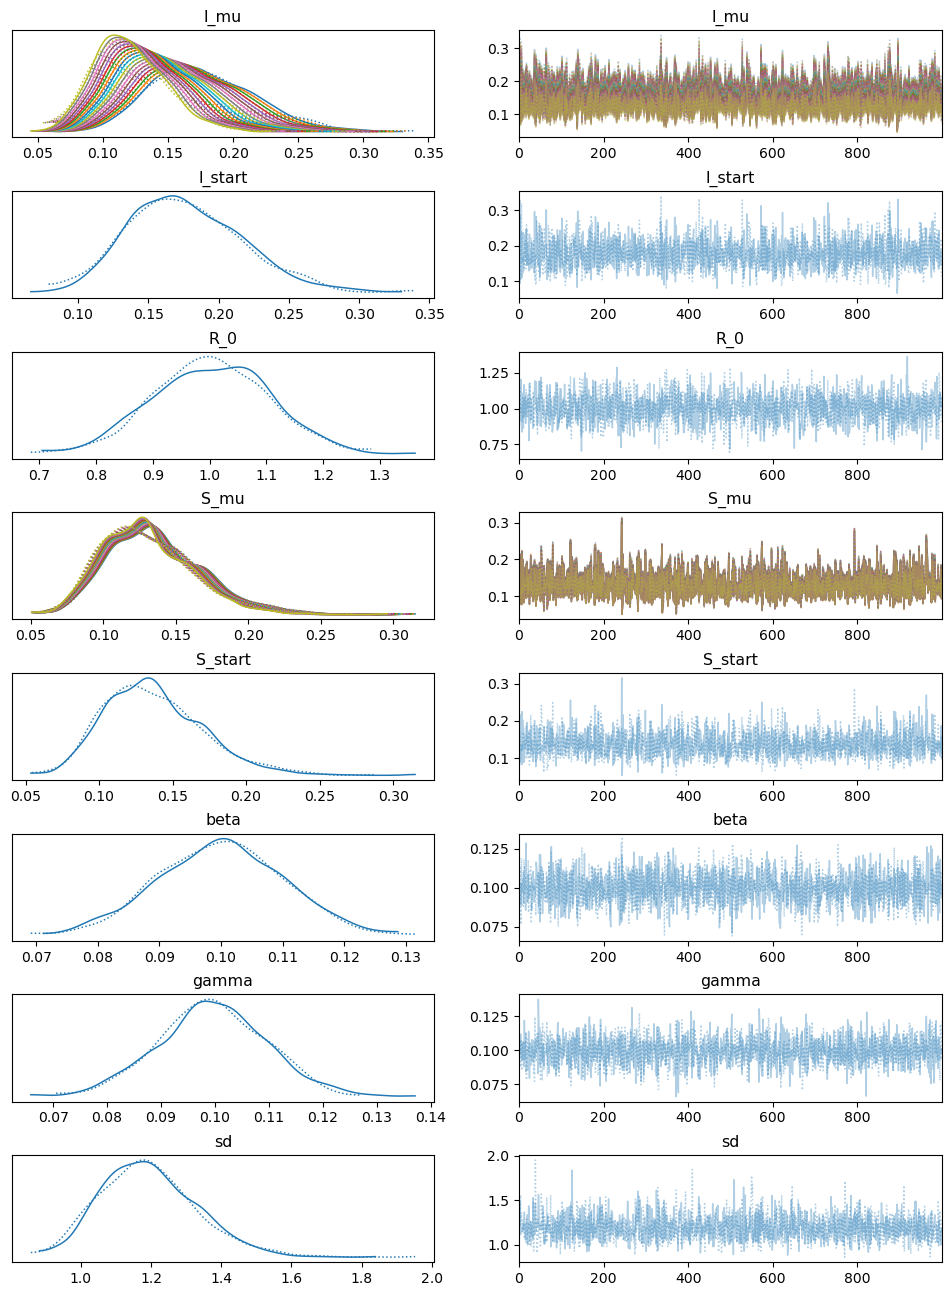

In [72]:

az.plot_trace(trace)
plt.subplots_adjust(hspace=0.5)  # Increase the value to 
plt.show()


In [73]:
ppc = pm.sample_posterior_predictive(trace, var_names=['S','I'], model=model)

Sampling: [I, S]


Output()

In [64]:
ppc

Inference data with groups:
	> posterior_predictive
	> observed_data

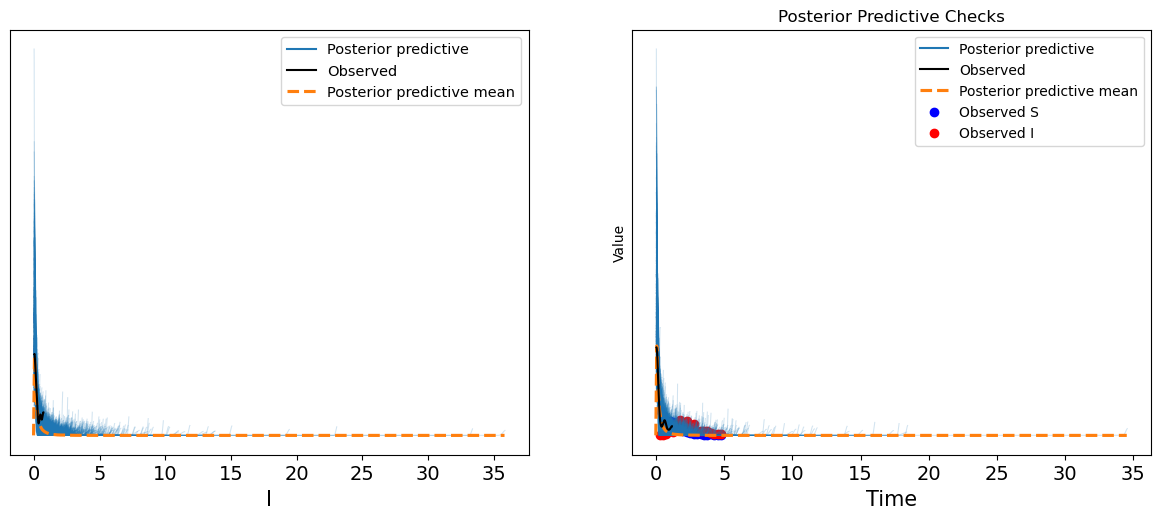

In [74]:
az.plot_ppc(ppc)
plt.scatter(np.arange(0.25, 5, 0.25), yobs[:, 0], c='blue', label='Observed S')
plt.scatter(np.arange(0.25, 5, 0.25), yobs[:, 1], c='red', label='Observed I')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Posterior Predictive Checks')
plt.show()

In [186]:
import pandas as pd

# Read the CSV file into a DataFrame
cases_df = pd.read_csv('cases.csv')

# Display the first few rows of the DataFrame
cases_df.head()

,date,n
0,2020-02-23,1
1,2020-03-01,30
2,2020-03-08,217
3,2020-03-15,1215
4,2020-03-22,1438


In [210]:
import pymc as pm
import numpy as np

def seir_difference(S, E, I, R, beta, sigma, gamma):
    new_exposed = beta * S * I
    new_infected = sigma * E
    new_recovered = gamma * I

    S_next = S - new_exposed
    E_next = E + new_exposed - new_infected
    I_next = I + new_infected - new_recovered
    R_next = R + new_recovered

    return S_next, E_next, I_next, R_next, new_infected

# Observed data (replace with your actual data)
observed_new_cases = (cases_df.n/5000000).values

with pm.Model() as model:
    # Priors for parameters
    beta = pm.HalfNormal('beta', sigma=1)
    sigma = pm.HalfNormal('sigma', sigma=1)
    gamma = pm.HalfNormal('gamma', sigma=1)

    # Initial conditions
    S0 = pm.Beta('S0', alpha=2, beta=2)
    E0 = pm.Beta('E0', alpha=2, beta=2)
    I0 = pm.Beta('I0', alpha=2, beta=2)
    R0 = pm.Deterministic('R0', 1 - S0 - E0 - I0)
    

    # Ensure initial conditions sum to 1
    pm.Potential('sum_to_one', pm.math.eq(S0 + E0 + I0 + R0, 1))

    # Time points
    T = len(observed_new_cases)

    # Initialize states
    S = S0
    E = E0
    I = I0
    R = R0

    # Lists to store results
    new_cases = []

    for t in range(T):
        S, E, I, R, new_infected = seir_difference(S, E, I, R, beta, sigma, gamma)
        new_cases.append(new_infected.astype('float64'))

    # Convert list to NumPy array
    new_cases = np.array(new_cases)

    # Observations
    new_cases_det = pm.Deterministic('new_cases', new_cases)
    I_obs = pm.Normal('I_obs', mu=new_cases_det, sigma=0.1, observed=observed_new_cases)


ValueError: order must be one of 'C', 'F', 'A', or 'K' (got 'new_cases')

<Axes: >

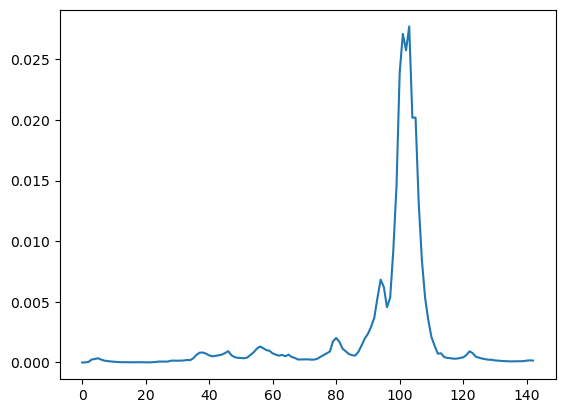

In [204]:
observed_new_cases.plot()
